In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler

from sklearn.decomposition import PCA

from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',1000)

In [2]:
df_por = pd.read_pickle('df_por-modelling-RFE-range_G3_5-repaired_G3_0_values.pkl')

df_por.head()

,school,sex,studytime,schoolsup,paid,higher,internet,romantic,absences,Mjob_health,Mjob_teacher,Fjob_at_home,Fjob_teacher,reason_course,reason_other,G3
0,1,1,2,1,0,1,0,0,2,0,0,0,1,1,0,3
1,1,1,2,0,0,1,1,0,2,0,0,0,0,1,0,3
2,1,1,2,1,0,1,1,0,1,0,0,0,0,0,1,3
3,1,1,3,0,0,1,1,1,2,1,0,0,0,0,0,4
4,1,1,2,0,0,1,0,0,2,0,0,0,0,0,0,4


## PCA 

In [3]:
X = np.array(df_por.drop('G3',axis = 1))

In [4]:
sc = MinMaxScaler()
sc.fit(X)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [5]:
X = sc.transform(X)

X

array([[1.        , 1.        , 0.33333333, ..., 1.        , 1.        ,
        0.        ],
       [1.        , 1.        , 0.33333333, ..., 0.        , 1.        ,
        0.        ],
       [1.        , 1.        , 0.33333333, ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.        , 1.        , 0.33333333, ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ]])

In [6]:
pca = PCA()
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

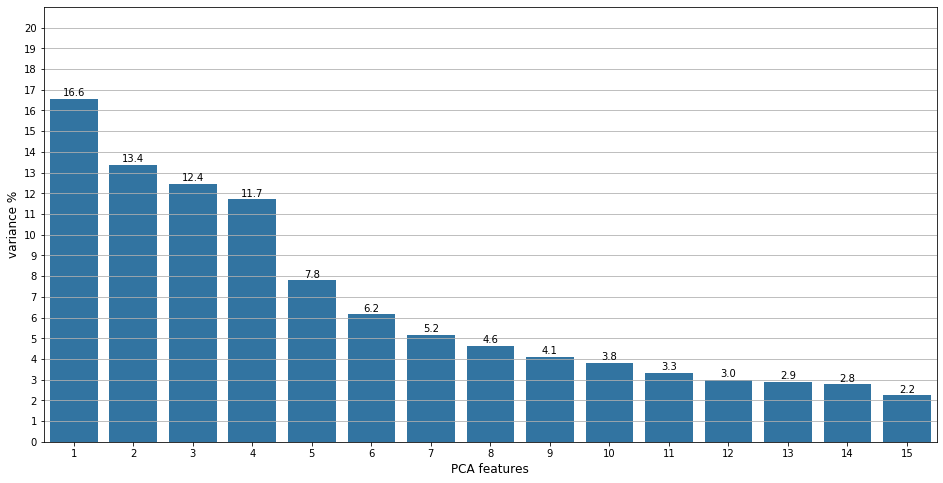

In [7]:
plt.figure(figsize = (16,8))
ax = sns.barplot(list(range(1,pca.n_components_ + 1)),pca.explained_variance_ratio_ * 100,color = '#1f77b4')
plt.yticks(np.arange(0,21,1))
plt.ylim(0,21)
ax.yaxis.grid(True)
plt.xlabel('PCA features',fontsize = 12)
plt.ylabel('variance %',fontsize = 12)

for rect,label in zip(ax.patches,np.around(pca.explained_variance_ratio_ * 100,1)):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2,height + 0.05,label,ha = 'center',va = 'bottom');

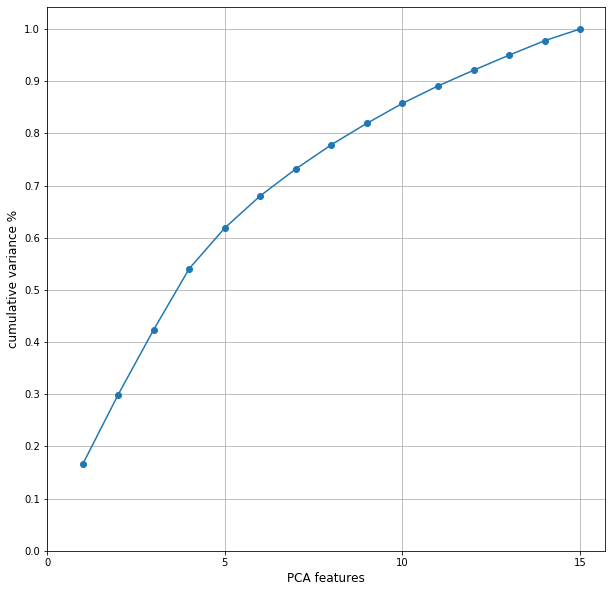

In [8]:
plt.figure(figsize = (10,10))
plt.plot(list(range(1,pca.n_components_ + 1)),np.cumsum(pca.explained_variance_ratio_),marker = 'o')
plt.xticks(np.arange(0,16,5))
plt.yticks(np.arange(0,1.1,0.1))
plt.xlabel('PCA features',fontsize = 12)
plt.ylabel('cumulative variance %',fontsize = 12)
plt.grid();

## KMeans

In [9]:
df_por_pca = pd.DataFrame(pca.transform(X))
df_por_pca = df_por_pca.iloc[:,:4]

df_por_pca.shape

(649, 4)

In [10]:
clusters = range(1,10)
inertias = []

for k in clusters:
    model = KMeans(n_clusters = k)
    model.fit(df_por_pca)
    inertias.append(model.inertia_)

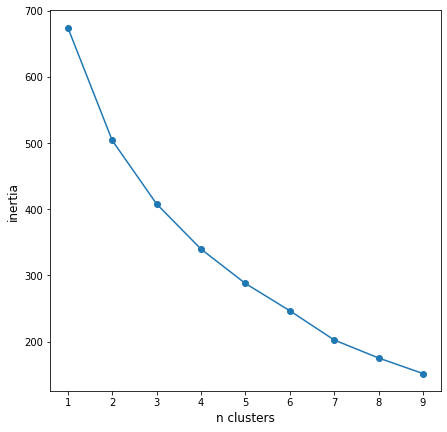

In [11]:
plt.figure(figsize = (7,7))
plt.plot(clusters,inertias,'-o')
plt.xlabel('n clusters',fontsize = 12)
plt.ylabel('inertia',fontsize = 12)
plt.xticks(clusters);

In [12]:
model = KMeans(n_clusters = 6,random_state = 42)
model.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [13]:
y_kmeans = model.predict(X)

In [14]:
silhouette_coefficient = silhouette_score(df_por_pca,y_kmeans)

silhouette_coefficient

0.34012841775762526

In [15]:
y_kmeans = pd.DataFrame(y_kmeans)

y_kmeans.columns = ['cluster']

In [16]:
df_por_original = pd.read_pickle('df_por_range-G3-5_repaired-G3-0-values.pkl')

df_por = pd.concat([df_por_original,y_kmeans],axis = 1)

df_por.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,cluster
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4,0,11,3,0
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2,9,11,3,0
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6,12,13,3,1
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,no,yes,yes,yes,yes,yes,3,2,2,1,1,5,0,14,14,4,0
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,no,no,yes,yes,no,no,4,3,2,1,2,5,0,11,13,4,1


In [17]:
df_por_original['G3'].value_counts().sort_index()

1      8
2     56
3    309
4    230
5     46
Name: G3, dtype: int64

In [18]:
df_por['cluster'].value_counts().sort_index()

0    147
1    103
2     96
3     57
4    128
5    118
Name: cluster, dtype: int64

### Cluster '0'

In [19]:
df_por_cluster_0 = df_por[df_por['cluster'] == 0]

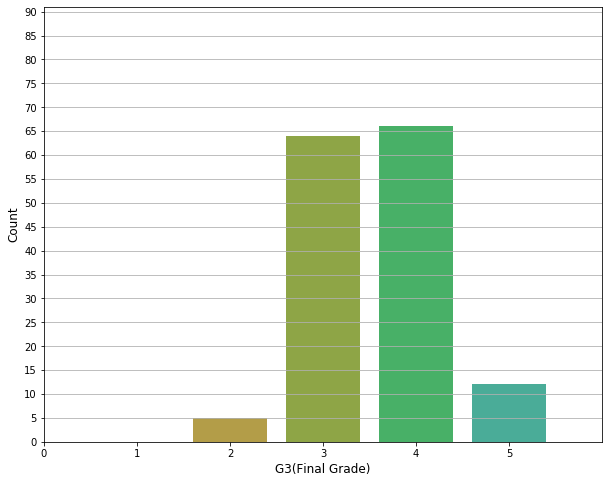

In [20]:
plt.figure(figsize = (10,8))
ax = sns.countplot(df_por_cluster_0['G3'],order = list(range(0,11)))
plt.xticks(np.arange(0,6))
plt.yticks(np.arange(0,91,5))
plt.xlim(0,6)
plt.ylim(0,91)
ax.yaxis.grid(True)
plt.xlabel('G3(Final Grade)',fontsize = 12)
plt.ylabel('Count',fontsize = 12);

In [21]:
def grades_table(df):
    total = df['G3'].value_counts().sort_index()
    percentage = round(df['G3'].value_counts(normalize = True).sort_values(ascending = False),2) * 100
    df_grades = pd.concat([total,percentage],axis = 1,keys = ['total','percentage'])
    missing_grades = list(set(range(0,6)) - set(total.index))
    for grade in missing_grades:
        df_missing_grade = pd.DataFrame([[0,0]],columns = ['total','percentage'],index = [grade])
        df_grades = df_grades.append(df_missing_grade).sort_index()
    return df_grades

In [22]:
grades_table(df_por_cluster_0)

,total,percentage
0,0,0.0
1,0,0.0
2,5,3.0
3,64,44.0
4,66,45.0
5,12,8.0


### Cluster '1'

In [23]:
df_por_cluster_1 = df_por[df_por['cluster'] == 1]

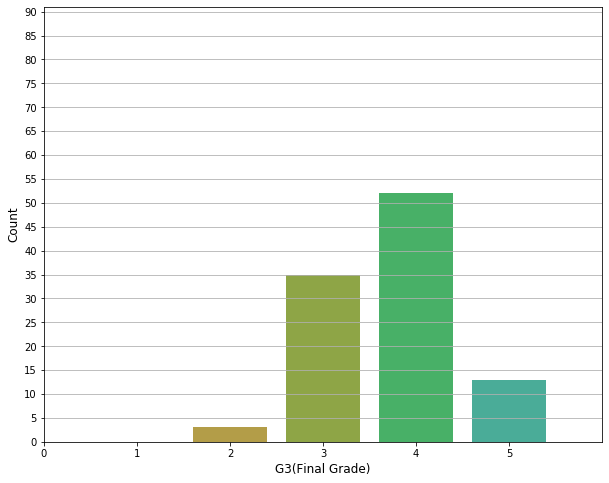

In [24]:
plt.figure(figsize = (10,8))
ax = sns.countplot(df_por_cluster_1['G3'],order = list(range(0,11)))
plt.xticks(np.arange(0,6))
plt.yticks(np.arange(0,91,5))
plt.xlim(0,6)
plt.ylim(0,91)
ax.yaxis.grid(True)
plt.xlabel('G3(Final Grade)',fontsize = 12)
plt.ylabel('Count',fontsize = 12);

In [25]:
grades_table(df_por_cluster_1)

,total,percentage
0,0,0.0
1,0,0.0
2,3,3.0
3,35,34.0
4,52,50.0
5,13,13.0


### Cluster '2'

In [26]:
df_por_cluster_2 = df_por[df_por['cluster'] == 2]

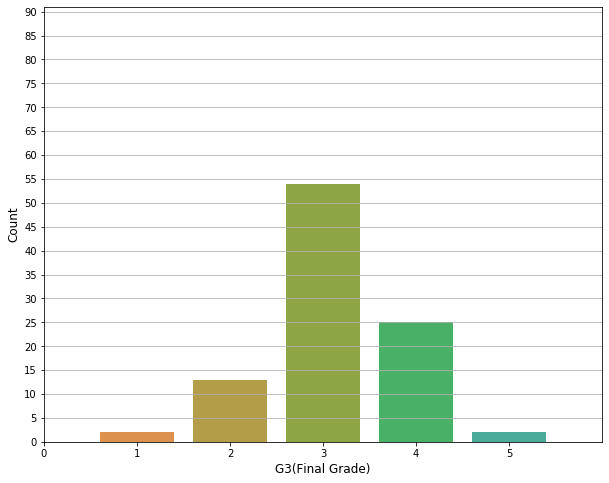

In [27]:
plt.figure(figsize = (10,8))
ax = sns.countplot(df_por_cluster_2['G3'],order = list(range(0,11)))
plt.xticks(np.arange(0,6))
plt.yticks(np.arange(0,91,5))
plt.xlim(0,6)
plt.ylim(0,91)
ax.yaxis.grid(True)
plt.xlabel('G3(Final Grade)',fontsize = 12)
plt.ylabel('Count',fontsize = 12);

In [28]:
grades_table(df_por_cluster_2)

,total,percentage
0,0,0.0
1,2,2.0
2,13,14.0
3,54,56.0
4,25,26.0
5,2,2.0


### Cluster '3'

In [29]:
df_por_cluster_3 = df_por[df_por['cluster'] == 3]

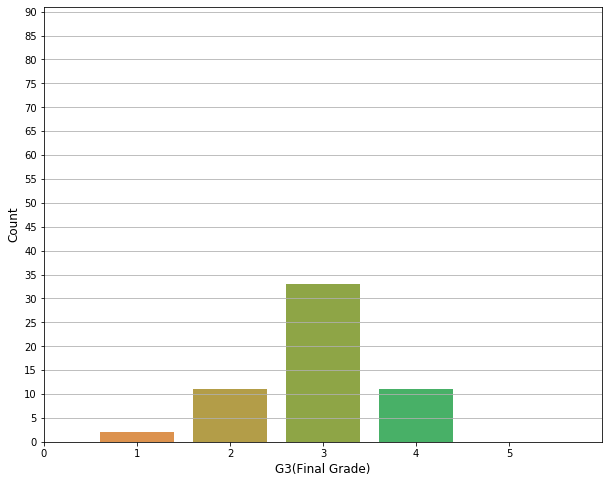

In [30]:
plt.figure(figsize = (10,8))
ax = sns.countplot(df_por_cluster_3['G3'],order = list(range(0,11)))
plt.xticks(np.arange(0,6))
plt.yticks(np.arange(0,91,5))
plt.xlim(0,6)
plt.ylim(0,91)
ax.yaxis.grid(True)
plt.xlabel('G3(Final Grade)',fontsize = 12)
plt.ylabel('Count',fontsize = 12);

In [31]:
grades_table(df_por_cluster_3)

,total,percentage
0,0,0.0
1,2,4.0
2,11,19.0
3,33,58.0
4,11,19.0
5,0,0.0


### Cluster '4'

In [32]:
df_por_cluster_4 = df_por[df_por['cluster'] == 4]

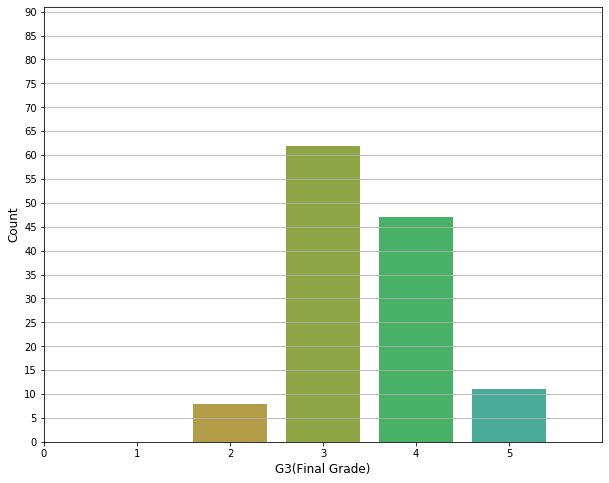

In [33]:
plt.figure(figsize = (10,8))
ax = sns.countplot(df_por_cluster_4['G3'],order = list(range(0,11)))
plt.xticks(np.arange(0,6))
plt.yticks(np.arange(0,91,5))
plt.xlim(0,6)
plt.ylim(0,91)
ax.yaxis.grid(True)
plt.xlabel('G3(Final Grade)',fontsize = 12)
plt.ylabel('Count',fontsize = 12);

In [34]:
grades_table(df_por_cluster_4)

,total,percentage
0,0,0.0
1,0,0.0
2,8,6.0
3,62,48.0
4,47,37.0
5,11,9.0


### Cluster '5'

In [35]:
df_por_cluster_5 = df_por[df_por['cluster'] == 5]

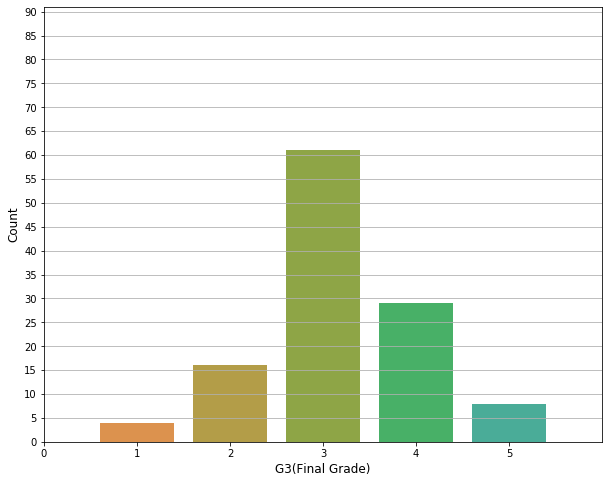

In [36]:
plt.figure(figsize = (10,8))
ax = sns.countplot(df_por_cluster_5['G3'],order = list(range(0,11)))
plt.xticks(np.arange(0,6))
plt.yticks(np.arange(0,91,5))
plt.xlim(0,6)
plt.ylim(0,91)
ax.yaxis.grid(True)
plt.xlabel('G3(Final Grade)',fontsize = 12)
plt.ylabel('Count',fontsize = 12);

In [37]:
grades_table(df_por_cluster_5)

,total,percentage
0,0,0.0
1,4,3.0
2,16,14.0
3,61,52.0
4,29,25.0
5,8,7.0


### Cluster Distributions

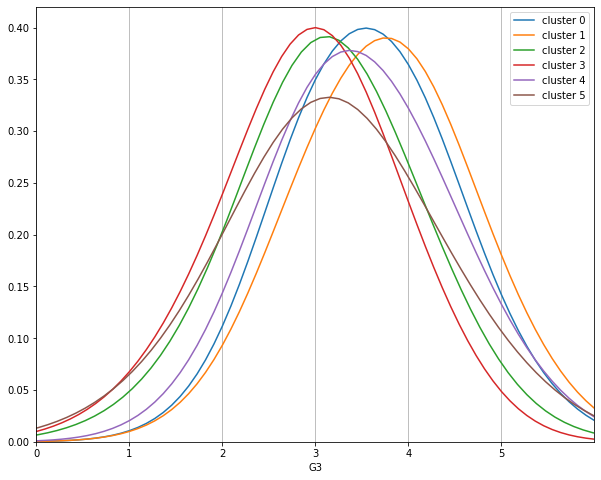

In [38]:
fig = plt.figure(figsize = (10,8))
ax = fig.gca()
sns.distplot(df_por_cluster_0['G3'],hist = False,kde_kws = {'bw':1},bins = np.arange(0,10),label = 'cluster 0')
sns.distplot(df_por_cluster_1['G3'],hist = False,kde_kws = {'bw':1},bins = np.arange(0,10),label = 'cluster 1')
sns.distplot(df_por_cluster_2['G3'],hist = False,kde_kws = {'bw':1},bins = np.arange(0,10),label = 'cluster 2')
sns.distplot(df_por_cluster_3['G3'],hist = False,kde_kws = {'bw':1},bins = np.arange(0,10),label = 'cluster 3')
sns.distplot(df_por_cluster_4['G3'],hist = False,kde_kws = {'bw':1},bins = np.arange(0,10),label = 'cluster 4')
sns.distplot(df_por_cluster_5['G3'],hist = False,kde_kws = {'bw':1},bins = np.arange(0,10),label = 'cluster 5')
plt.xticks(np.arange(0,6))
plt.xlim(0,6)
ax.xaxis.grid(True)
plt.legend();

In [39]:
# pd.to_pickle(df_por_cluster_0,'df_por_cluster_0-rfe.pkl')
# pd.to_pickle(df_por_cluster_1,'df_por_cluster_1-rfe.pkl')
# pd.to_pickle(df_por_cluster_2,'df_por_cluster_2-rfe.pkl')
# pd.to_pickle(df_por_cluster_3,'df_por_cluster_3-rfe.pkl')
# pd.to_pickle(df_por_cluster_4,'df_por_cluster_4-rfe.pkl')
# pd.to_pickle(df_por_cluster_5,'df_por_cluster_5-rfe.pkl')
# pd.to_pickle(df_por_cluster_6,'df_por_cluster_6-rfe.pkl')